# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [165]:
# Change here using YOUR first and last names
fn1 = "julia"
ln1 = "cuvelier"
fn2 = "marius"
ln2 = "ortega"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_cuvelier_julia_and_ortega_marius.ipynb


In [166]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

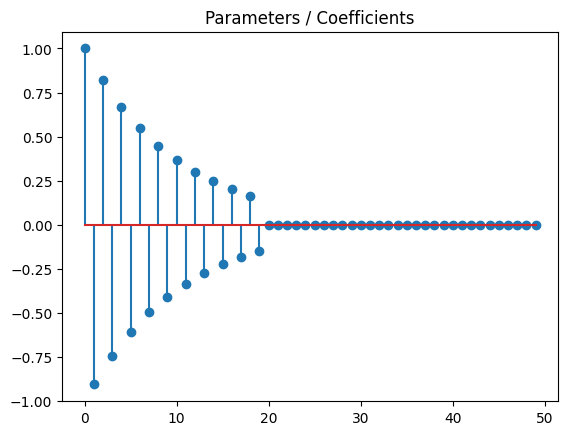

In [168]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [169]:
from numpy.random import multivariate_normal
from scipy.linalg import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [170]:
A, b = simu_linreg(coefs)
#A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

#### Prox-L1

To find $prox_{L1}$ we ought to solve the following problem :
$$
\text{prox}_{(\lambda \vert\vert z \vert\vert_1)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \Vert z \Vert_1 \right\} \\
$$

We can reformulate the problem by writting the optimal condition : 
$$
0 \in \nabla \left( \frac{1}{2} \Vert x - z\Vert_2^2 \right) + \partial (\lambda \Vert z\Vert_1) \Leftrightarrow 0 \in z - x + \lambda\partial\Vert z\Vert_1
$$

Let's rewrite the expression at the optimum $z^*$ :

$$
0 = z^* - x + \lambda\partial\Vert z^*\Vert_1 = z^* - x + \lambda sign(z^*) \Leftrightarrow z^* = x - sign(z^*) \\
$$

We substituate $z^*$ in the expression of the proximal operator :
$$
sign(z^*) = sign(x), \forall x, \lambda \Rightarrow z^* = x - sign(x)
$$

From there we can expression the proximal of $L_1 norm$ : 

$$
\begin{equation} \tag{1}
  \text{prox}_{(\lambda \frac{1}{2} \vert\vert z \vert\vert_2^2)}(x) = z^* = 
    \begin{cases}
      0 & \text{if }\vert x \vert \le \lambda\\
      x-\lambda sign(x) & \text{if } \vert x \vert > \lambda\\
    \end{cases}      
    \Rightarrow prox_{\lambda \vert\vert z \vert\vert_1}(x) = sign(x) \max(\vert x \vert - \lambda, 0)
\end{equation}
$$

#### Prox-L2

To find $prox_{L1}$ we ought to solve the following problem :
$$
\text{prox}_{(\lambda \frac{1}{2} \vert\vert z \vert\vert_2^2)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \frac{1}{2} \Vert z \Vert_2^2 \right\} \\
$$

We can reformulate the problem by writting the optimal condition :
$$
0 = \nabla \left( \frac{1}{2} \Vert x - z^*\Vert_2^2 \right) + \partial (\lambda \frac{1}{2} \Vert z^*\Vert_2^2) \Leftrightarrow 0 = z^* - x + \lambda z^* \Leftrightarrow z^* = \frac{x}{1+\lambda}
$$

The proximal operator of $L_2norm$ is then given by :
$$
\begin{equation} \tag{2}
\text{prox}_{(\lambda \frac{1}{2} \vert\vert z \vert\vert_2^2)}(x) = z^* = \frac{x}{1+\lambda}
\end{equation}
$$

In [171]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    prox = np.sign(x)*np.maximum(np.abs(x)-lmbd, 0)
    return prox # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    x = lmbd * norm(x, ord=1)
    return x # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    prox = x/(1 + lmbd)
    return prox # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    x = (1/2)*lmbd * norm(x, ord=2)**2
    return x # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

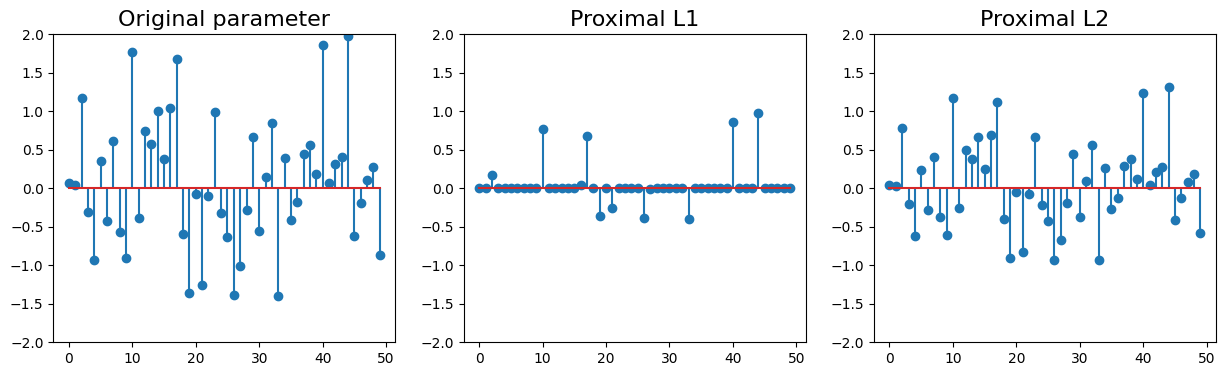

In [172]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

#### L1-norm

We notice that all values that are greater that lambda are scaled down by the value of lambda and the other (i.e. less important) parameters are put to 0. The L1 regulariation promotes sparcity which induces feature selection and helps accelerating gradient descent. 

#### L2-norm squared

L2-squared normalization tends to scale down all components without promoting sparsity like L1 normalization. it smoothes parameters' distribution. 

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

Let's start by computing the gradient of $f$ for both cases :

#### Linear regression

$$
\begin{align*}

\nabla f(x) &= \frac{1}{2n} \nabla \Vert b - Ax \Vert_2^2 \\
&= \frac{1}{n} A^T (b - Ax) 

\end{align*}
$$

#### Logistic regression

$$

\begin{align*}
\nabla f(x) &= \frac{1}{n} \nabla \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)) \\
            &= \frac{1}{n} \sum_{i=1}^n \frac{-b_i a_i \exp(-b_i a_i^\top x)}{1 + \exp(-b_i a_i^\top x)} = \frac{1}{n} \sum_{i=1}^n -b_ia_i(1 - \sigma(b_i a_i^\top x)), \text{because  } 1-\sigma(z) = \frac{e^{-z}}{1+e^{-z}} \\
\end{align*}
$$

In [173]:
def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    loss = (1/(2*n_samples)) * norm(b - A@x, ord=2)**2
    return loss

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    grad = 1/n_samples * A.T @ (A@x-b)
    return grad

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    loss = np.mean(np.log(1 + np.exp(-b * A.dot(x))))
    return loss

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    #grad = np.mean((-b * A) * (1-sigmoid(-b * A.dot(x))), axis=1)
    n = len(b)
    sigmoid_x = 1/(1 + np.exp(-A.dot(x)))
    grad = -(1/n) * A.T.dot(b * (1 - sigmoid_x))
    return grad

# TO BE COMPLETED

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

We want to compute Lipschitz constants for linear and logistic regression losses : 

- #### For linear regression :
    $$
    f(x) = \frac{1}{2 n} \| b - A x \|_2^2 \Rightarrow \nabla f(x) = \frac{1}{n} A^\top(Ax-b) \Rightarrow \nabla^2 f(x) = \frac{1}{n} A^\top A
    $$
    
    By definition of the Lipschitz constant for linear regression :
    $$
    L_{linreg} = \frac{1}{n}\lambda_{max}(A^\top A)
    $$ 
    Thus, we can compute the Lipschitz constant using the operator norm of the matrix $X$ :
    $$
    L_{linreg} = \frac{1}{n}\lambda_{max}(A^{\top} A) = \frac{1}{n}\sigma_{max}^2(A) = \frac{1}{n}\Vert A \Vert_{op}^2
    $$

- #### For logistic regression :

    Here, we will use 2nd order smoothness definition :
    $$
    \nabla^2 f(x) \preceq L_{linreg}I_d
    $$

    We first compute the Hessian of the logistic regression loss :
    $$
    \begin{align*}
    
    & f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)) \\ 
    & \nabla f(x) = \frac{1}{n} \sum_{i=1}^n \frac{-b_i a_i \exp(-b_i a_i^\top x)}{1 + \exp(-b_i a_i^\top x)} = \frac{1}{n} \sum_{i=1}^n \frac{b_i a_i}{1 + \exp(b_i a_i^\top x)} \\
    & \nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n \frac{b_i^2 a_i a_i^\top \exp(b_i a_i^\top x)}{(1 + \exp(b_i a_i^\top x))^2} = \frac{1}{n} \sum_{i=1}^n \sigma(b_ia_i^\top x)(1-\sigma(b_i a_i^\top x))a_i a_i^\top\preceq \frac{1}{4n} \sum_{i=1}^n a_i a_i^T = \frac{1}{4n} A^\top A
    
    \end{align*}
    $$

    From there, we can retrieve the Lipschitz constant for logistic regression :
    $$
    \frac{1}{4n} A^\top A \preceq L_{logreg} I_d \Rightarrow L_{logreg} = \frac{1}{4n} \lambda_{max}(A^\top A) = \frac{1}{4n} \sigma^2_{max}(A) = \frac{1}{4n} \Vert A \Vert_{op}^2
    $$

In [174]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A): # https://math.stackexchange.com/questions/2813884/lipschitz-constant-of-ax-b-22-and-atax-b
    """Lipschitz constant for linear squares loss"""    
    # TODO
    return (1/n_samples) * norm(A, ord=2)**2

# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A): # https://math.stackexchange.com/questions/3592594/lipschitz-constant-of-negative-log-likelihood-function
    """Lipschitz constant for logistic loss"""    
    # TODO
    return (1/4)*n_samples * norm(A, ord=2)**2
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new=prox_R(x-step*grad_f(x),lmbd*step)  # proximal operator of R at x - step * grad_f(x), with a step size of lmbd*step

        x=x_new
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [175]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new=prox_R(z-step*grad_f(z),lmbd*step)
        t_new=(1+np.sqrt(1+4*t**2))/2
        z=x_new+((t-1)/t_new)*(x_new-x)
        x=x_new
        t=t_new
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [176]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

#### Compute a precise minimum and a precise minimizer of the linear regression with L2 penalization problem using the parameters give above. This can be done by using APGD with 1000 iterations.

In [188]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)

x, objectives, errors = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=1000, verbose=False)

minimum = objectives[-1]
minimizer = x

print(f'Precise minimum of the linear regression {minimum}')
print(f'Precise minimizer of the linear regression {" | ".join(map(lambda x: f"{str(x)}", minimizer))}')

Precise minimum of the linear regression 0.49623847445277247
Precise minimizer of the linear regression 1.0162171828425175 | -0.9025307042189117 | 0.8010250971731018 | -0.7488090497306041 | 0.6348955787002444 | -0.5568350976413032 | 0.5353337239279217 | -0.5516859582655859 | 0.47112919321962776 | -0.41194462546545424 | 0.3864044541559446 | -0.3568139082593754 | 0.28029370475909904 | -0.30083831735353117 | 0.24655405244220158 | -0.2626022234503174 | 0.20309803354093514 | -0.10354128267039278 | 0.15956774531120857 | -0.2349415302716863 | 0.09304278122594996 | 0.014322266624034977 | -0.055762302207092454 | 0.051975890524920465 | -0.03820584688995084 | 0.04492547104972683 | -0.05351642142348481 | 0.00899450613939996 | -0.02659299641612574 | 0.04979048115896329 | -0.07768312660340222 | 0.006614684574079079 | 0.055180996136045685 | -0.0638594087845637 | 0.02948162729315775 | -0.07816258763840332 | 0.034486915390797034 | 0.041900819025436915 | -0.018164605555097954 | -0.03631496847774776 | 0.

#### Compare the convergences of PGD and APGD, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [189]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)

x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=800, verbose=False)
x_APGD, objectives_APGD, errors_APGD = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=800, verbose=False)

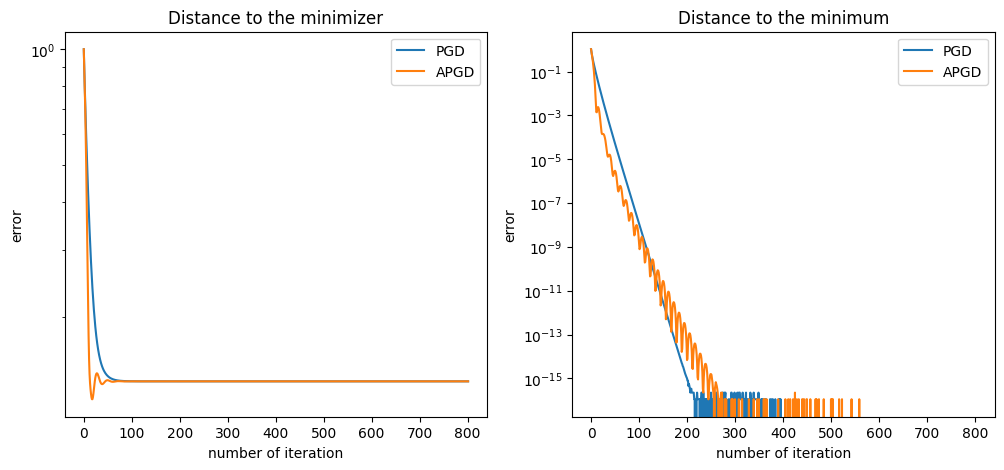

In [179]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(errors_PGD, label = "PGD")
plt.plot(errors_APGD, label = "APGD")
plt.xlabel("number of iteration")
plt.ylabel("error")
plt.yscale("log")
plt.title("Distance to the minimizer")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(objectives_PGD - objectives_PGD[-1], label = "PGD")
plt.plot(objectives_APGD - objectives_APGD[-1], label = "APGD")
plt.xlabel("number of iteration")
plt.ylabel("error")
plt.yscale("log")
plt.title("Distance to the minimum")
plt.legend()

plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

In [180]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)


# L1 norm
x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)

x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_PGD, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_APGD, verbose=False)

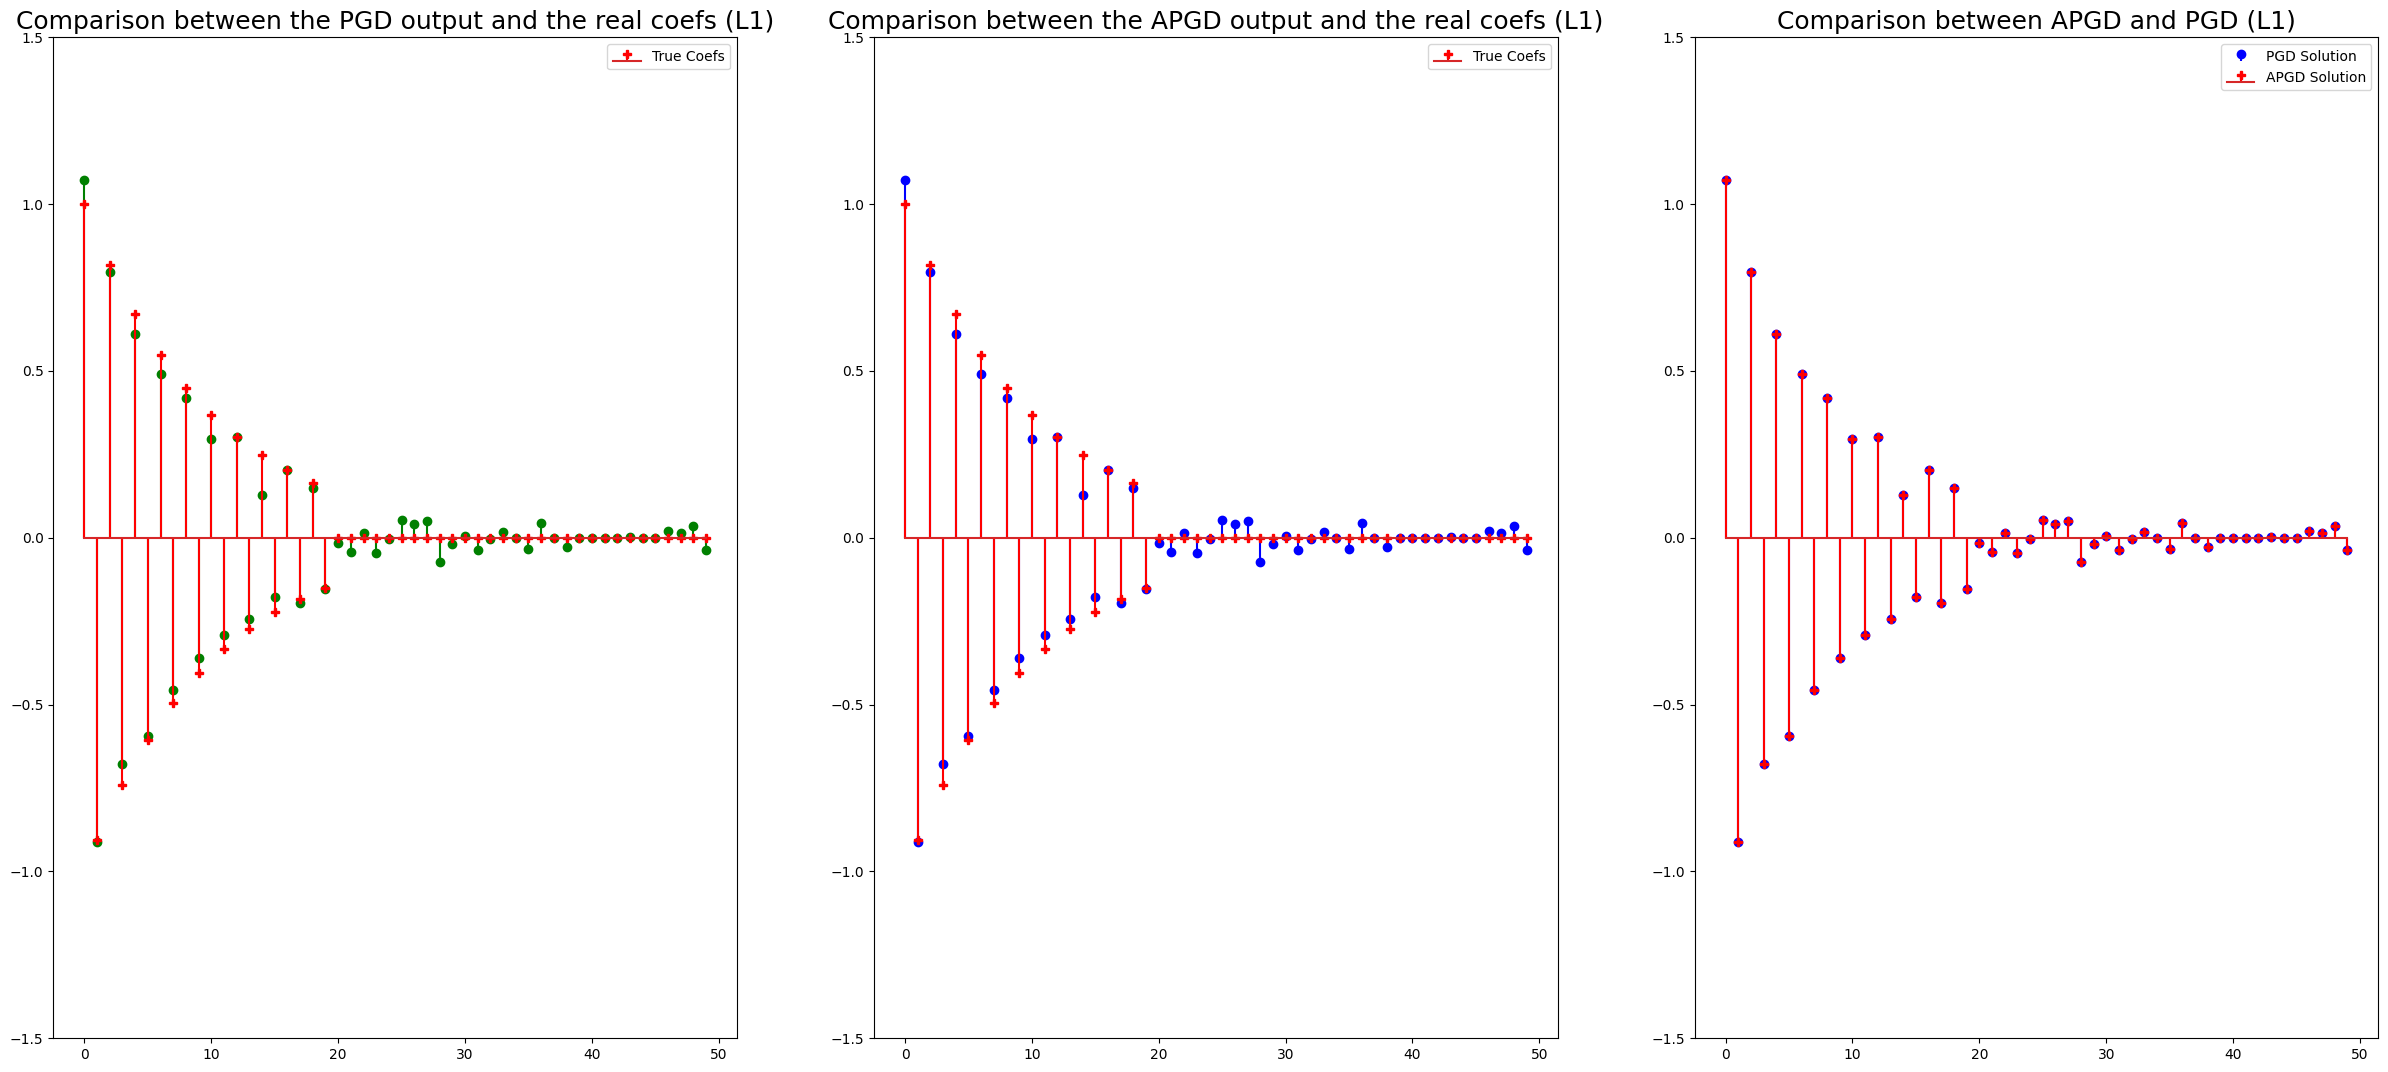

In [181]:

plt.figure(figsize=(30, 13))

#  solution obtained by PGD 
plt.subplot(1, 3, 1)
plt.stem(x_PGD, linefmt='g-', markerfmt='go', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the PGD output and the real coefs (L1)", fontsize=18)
plt.ylim([-1.5, 1.5])
plt.legend()

# solution obtained by APGD 
plt.subplot(1, 3, 2)
plt.stem(x_APGD, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the APGD output and the real coefs (L1)", fontsize=18)
plt.ylim([-1.5, 1.5])
plt.legend()

#comparison between APGD and PGD using plt.stem
plt.subplot(1, 3, 3)
plt.stem(x_PGD, linefmt='b-', markerfmt='bo', basefmt=' ', label='PGD Solution')
plt.stem(x_APGD, markerfmt='P', linefmt='red', label='APGD Solution')
plt.title("Comparison between APGD and PGD (L1)", fontsize=18)
plt.ylim([-1.5, 1.5])
plt.legend()

# Show the plot
plt.show()



we can see that with PGD or APGD we get results quite close to the real coefficients. On the last graph, we can see that in reality we have the same results for AGD and APGD, since the blue and red points overlap perfectly.

Let's do the same with  L2 norm

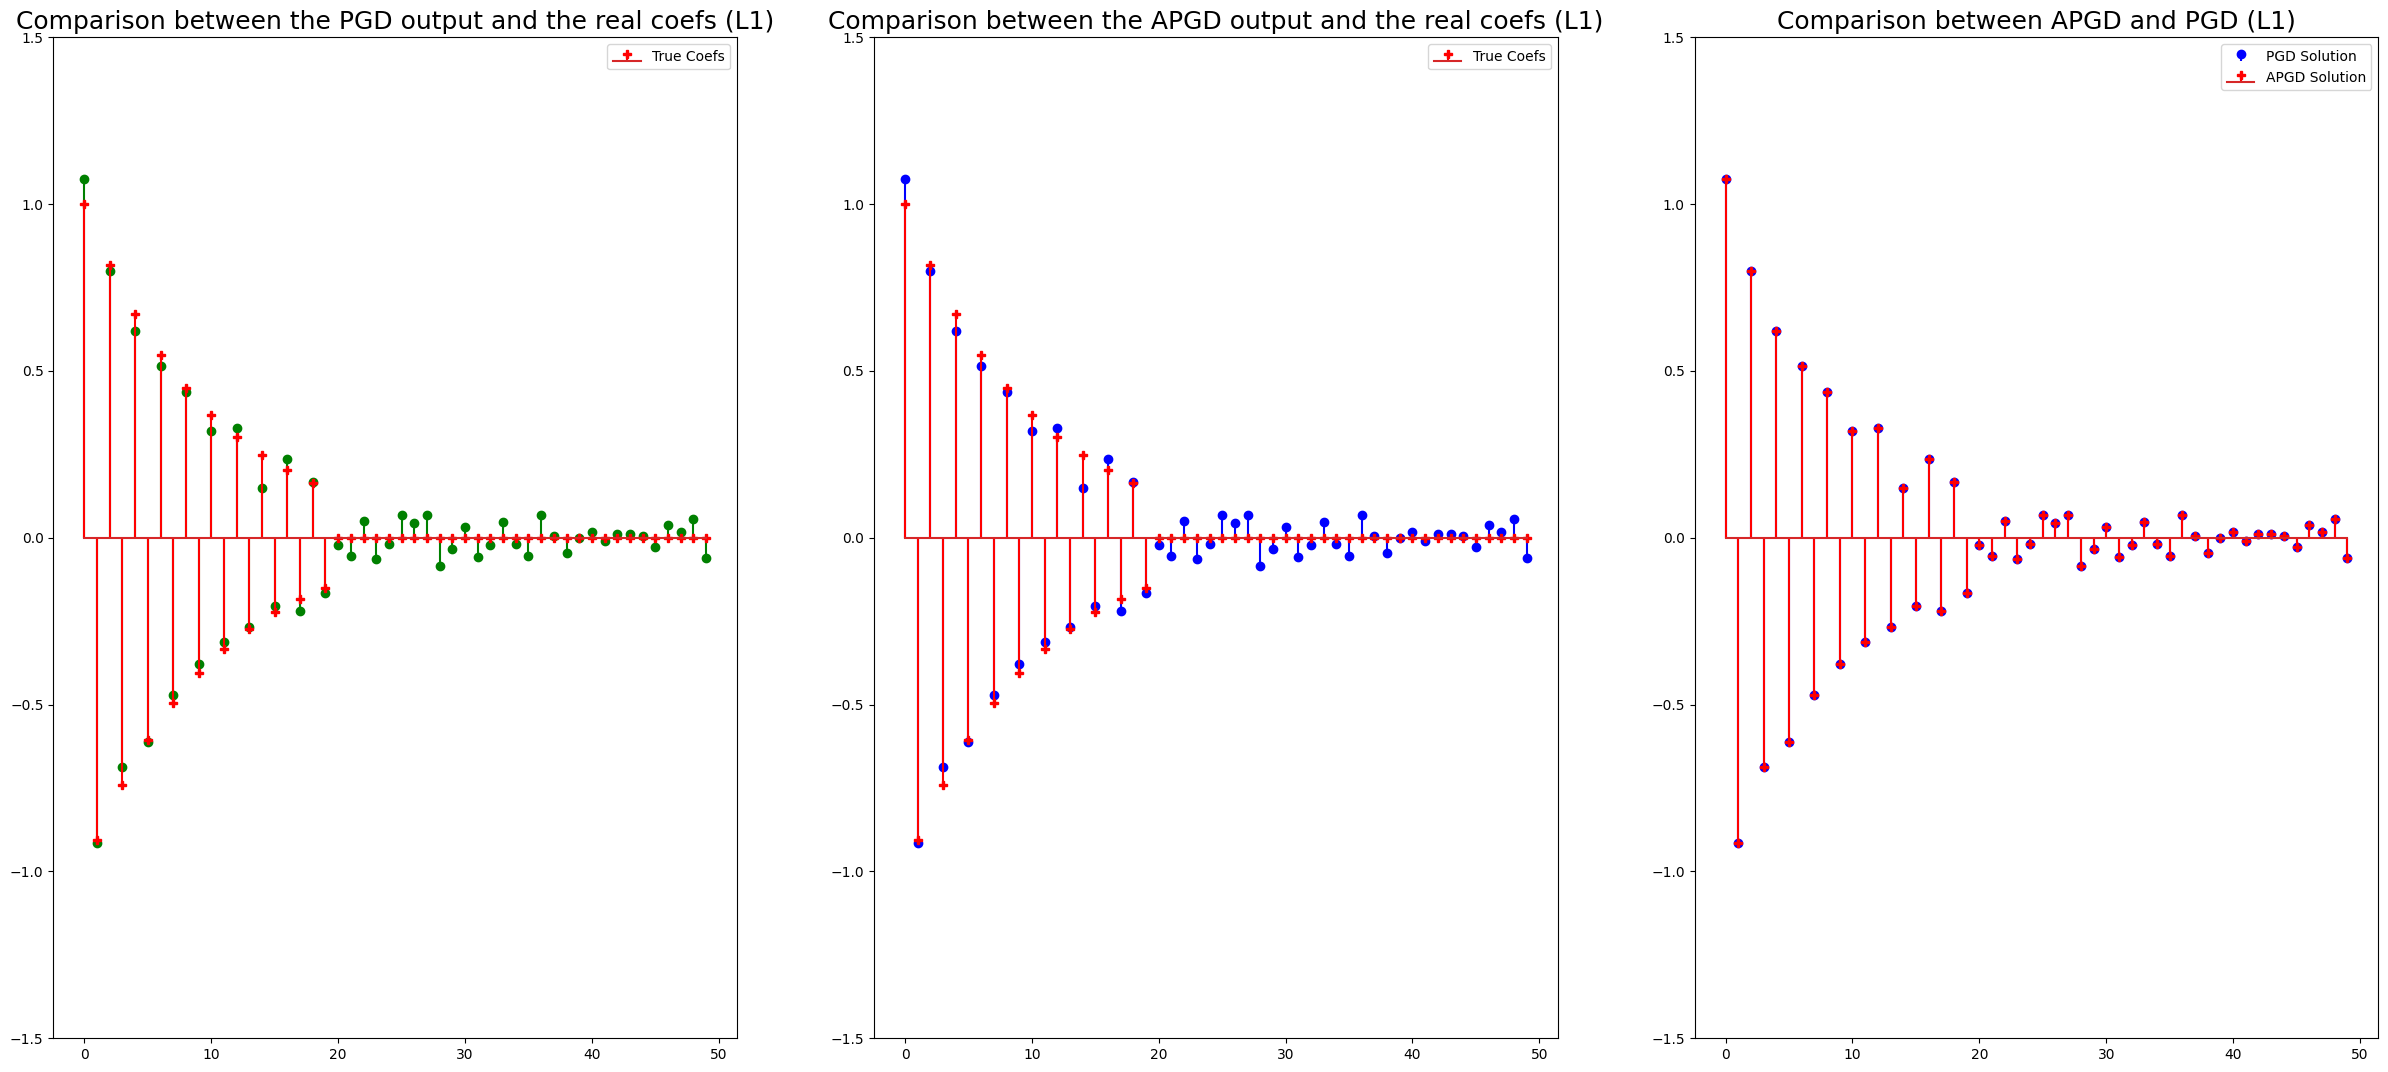

In [182]:
# L2 norm
x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)

x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_PGD, verbose=False)
x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_APGD, verbose=False)




plt.figure(figsize=(30, 13))

#  solution obtained by PGD 
plt.subplot(1, 3, 1)
plt.stem(x_PGD, linefmt='g-', markerfmt='go', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the PGD output and the real coefs (L1)", fontsize=18)
plt.ylim([-1.5, 1.5])
plt.legend()

# solution obtained by APGD 
plt.subplot(1, 3, 2)
plt.stem(x_APGD, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.stem(coefs, markerfmt="P", linefmt="red", label='True Coefs')
plt.title("Comparison between the APGD output and the real coefs (L1)", fontsize=18)
plt.ylim([-1.5, 1.5])
plt.legend()

#comparison between APGD and PGD using plt.stem
plt.subplot(1, 3, 3)
plt.stem(x_PGD, linefmt='b-', markerfmt='bo', basefmt=' ', label='PGD Solution')
plt.stem(x_APGD, markerfmt='P', linefmt='red', label='APGD Solution')
plt.title("Comparison between APGD and PGD (L1)", fontsize=18)
plt.ylim([-1.5, 1.5])
plt.legend()

# Show the plot
plt.show()

We have very similar results.

Question 2 : Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

In [190]:
#Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.

#let's choose the logistic regression with L1 regularizer

cor=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

er_PGD=[]
er_APGD=[]

labels = []

for i in cor:
    A, b = simu_logreg(coefs, corr=np.round(i,1))
    L=smoothness_const_loreg(A)
    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, verbose=False)

    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_PGD, verbose=False)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step = 1/L, lmbd=lmbd, n_iter=500, x_true = x_APGD, verbose=False)

    er_PGD.append(errors_PGD)
    er_APGD.append(errors_APGD)
    labels.append(f'Correlation {i}')

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 1.00e+00
      10 | 6.93e-01 | 1.00e+00
      20 | 6.93e-01 | 1.00e+00
      30 | 6.93e-01 | 1.00e+00
      40 | 6.93e-01 | 1.00e+00
      50 | 6.93e-01 | 1.00e+00
      60 | 6.93e-01 | 1.00e+00
      70 | 6.93e-01 | 1.00e+00
      80 | 6.93e-01 | 1.00e+00
      90 | 6.93e-01 | 1.00e+00
     100 | 6.93e-01 | 1.00e+00
     110 | 6.93e-01 | 1.00e+00
     120 | 6.93e-01 | 1.00e+00
     130 | 6.93e-01 | 1.00e+00
     140 | 6.93e-01 | 1.00e+00
     150 | 6.93e-01 | 1.00e+00
     160 | 6.93e-01 | 1.00e+00
     170 | 6.93e-01 | 1.00e+00
     180 | 6.93e-01 | 1.00e+00
     190 | 6.93e-01 | 1.00e+00
     200 | 6.93e-01 | 1.00e+00
     210 | 6.93e-01 | 1.00e+00
     220 | 6.93e-01 | 1.00e+00
     230 | 6.93e-01 | 1.00e+00
     240 | 6.93e-01 | 1.00e+00
     250 | 6.93e-01 | 1.00e+00
     260 | 6.93e-01 | 1.00e+00
     270 | 6.93e-01 | 1.00e+00
     280 | 6.93e-01 | 1.00e+00
     290 | 6.93e-01 | 1.00e+00
     300 | 6.93e-

In [184]:
er_PGD

[[1.0,
  0.9980039721731081,
  0.9960079444255961,
  0.9940119167574641,
  0.9920158891687121,
  0.9900198616593402,
  0.9880238342293478,
  0.9860278068787353,
  0.9840317796075025,
  0.9820357524156492,
  0.9800397253031757,
  0.9780436982700818,
  0.9760476713163674,
  0.9740516444420325,
  0.9720556176470769,
  0.9700595909315006,
  0.9680635642953036,
  0.9660675377384861,
  0.9640715112610475,
  0.9620754848629883,
  0.9600794585443082,
  0.958083432305007,
  0.9560874061450848,
  0.9540913800645416,
  0.9520953540633774,
  0.9500993281415919,
  0.9481033022991853,
  0.9461072765361573,
  0.9441112508525081,
  0.9421152252482375,
  0.9401191997233456,
  0.938123174277832,
  0.9361271489116971,
  0.9341311236249404,
  0.9321350984175624,
  0.9301390732895625,
  0.9281430482409407,
  0.9261470232716975,
  0.9241509983818322,
  0.9221549735713453,
  0.9201589488402363,
  0.9181629241885053,
  0.9161668996161523,
  0.9141708751231773,
  0.9121748507095799,
  0.9101788263753605,
  0.9

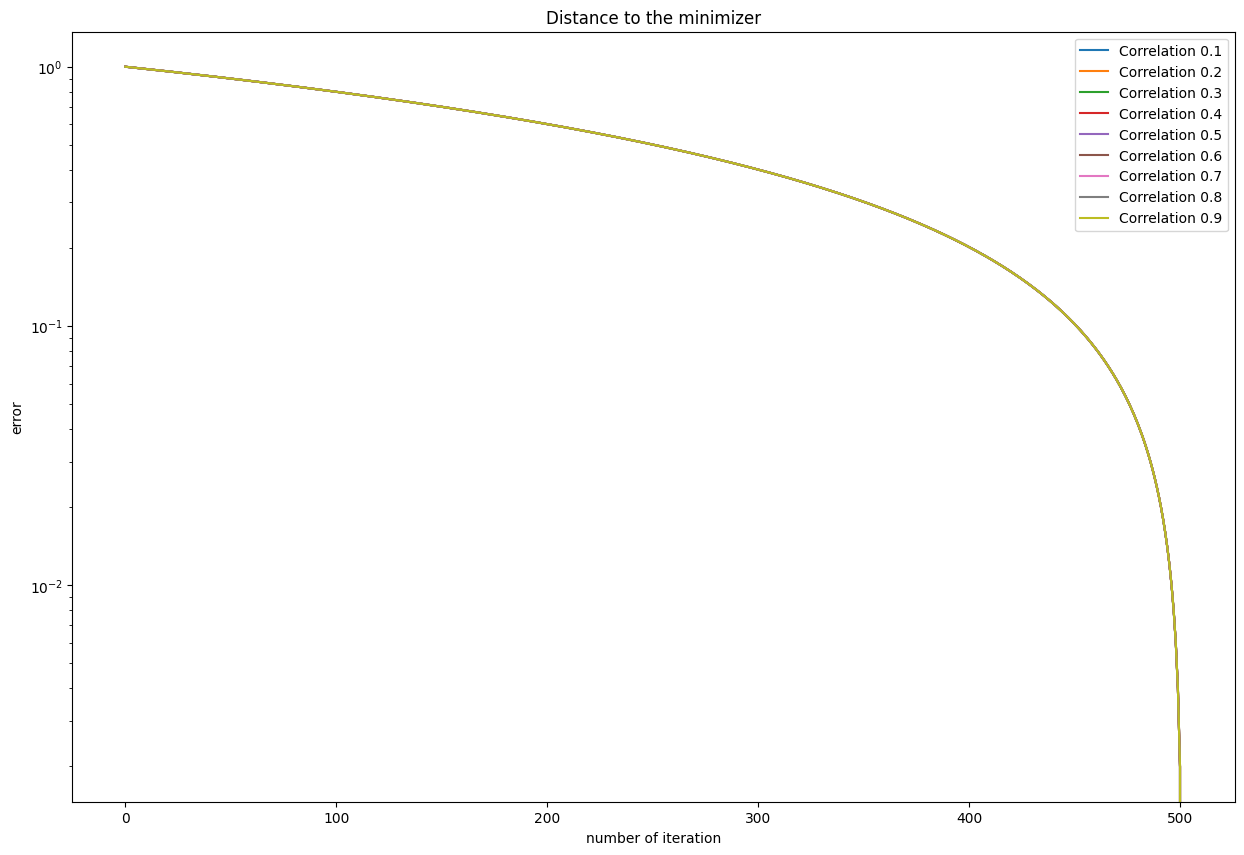

In [185]:
#plot the error in function of the correlation with all the different correlations
plt.figure(figsize=(15, 10))
for i in range(len(er_PGD)):
     plt.plot(er_PGD[i], label = labels[i])
plt.xlabel("number of iteration")
plt.ylabel("error")
plt.yscale("log")
plt.title("Distance to the minimizer")
plt.legend()
plt.show()



question 3 : Pick a different problem (logistic or linear) and a different regularization (L1 or L2),
#and study the influence of the level of penalization ( 𝜆 ) on the performance of the optimization algorithms.
#Explain. Analyse and explain the behavior of the solution vector when  𝜆  increases.

In [186]:
#linear probem with L2 regularization
A,b=simu_linreg(coefs)
L=smoothness_const_linreg(A)

lambdas = np.arange(0.1, 1, 0.1)

er_PGD=[]
er_APGD=[]
labels = []

for i in lambdas:
    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500)

    x_PGD, objectives_PGD, errors_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500, x_true = x_PGD)
    x_APGD, objectives_APGD, errors_APGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step = 1/L, lmbd=i, n_iter=500, x_true = x_APGD)

    er_PGD.append(errors_PGD)
    er_APGD.append(errors_APGD)
    labels.append(f'Lambda {i}')

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.35e+00 | 8.86e-01
      10 | 7.74e-01 | 3.81e-01
      20 | 7.42e-01 | 2.63e-01
      30 | 7.40e-01 | 2.34e-01
      40 | 7.40e-01 | 2.27e-01
      50 | 7.40e-01 | 2.25e-01
      60 | 7.40e-01 | 2.24e-01
      70 | 7.40e-01 | 2.24e-01
      80 | 7.40e-01 | 2.24e-01
      90 | 7.40e-01 | 2.24e-01
     100 | 7.40e-01 | 2.24e-01
     110 | 7.40e-01 | 2.24e-01
     120 | 7.40e-01 | 2.24e-01
     130 | 7.40e-01 | 2.24e-01
     140 | 7.40e-01 | 2.24e-01
     150 | 7.40e-01 | 2.24e-01
     160 | 7.40e-01 | 2.24e-01
     170 | 7.40e-01 | 2.24e-01
     180 | 7.40e-01 | 2.24e-01
     190 | 7.40e-01 | 2.24e-01
     200 | 7.40e-01 | 2.24e-01
     210 | 7.40e-01 | 2.24e-01
     220 | 7.40e-01 | 2.24e-01
     230 | 7.40e-01 | 2.24e-01
     240 | 7.40e-01 | 2.24e-01
     250 | 7.40e-01 | 2.24e-01
     260 | 7.40e-01 | 2.24e-01
     270 | 7.40e-01 | 2.24e-01
     280 | 7.40e-01 | 2.24e-01
     290 | 7.40e-01 | 2.24e-01
     300 | 7.40e-

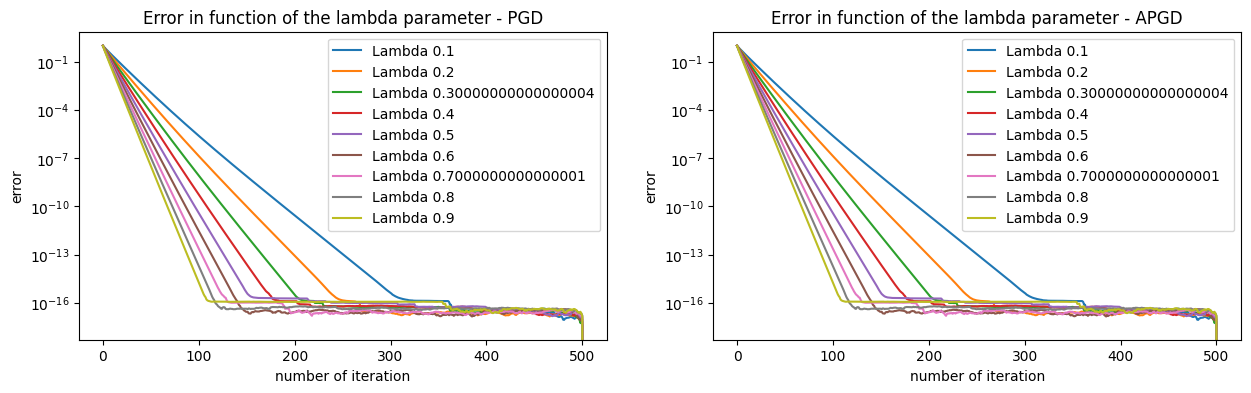

In [187]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
for i, e in enumerate(er_PGD):
    plt.plot(e, label = labels[i])
plt.legend()
plt.xlabel("number of iteration")
plt.ylabel("error")
plt.yscale("log")
plt.title("Error in function of the lambda parameter - PGD")
plt.legend()

plt.subplot(1, 2, 2)
for i, e in enumerate(er_APGD):
    plt.plot(e, label = labels[i])
plt.legend()
plt.xlabel("number of iteration")
plt.ylabel("error")
plt.yscale("log")
plt.title("Error in function of the lambda parameter - APGD")
plt.legend()

plt.show()